# OpenFOAM HRM Log Analysis

This program plots data from HRMFoam log files for analysis (i.e. net mass flux).
The data should already be extracted to HDF using ReadHRMLog
    
    @author Daniel Duke <daniel.duke@monash.edu>
    @copyright (c) 2020 LTRAC
    @license GPL-3.0+
    @version 0.0.1
    @date 02/11/2022
        __   ____________    ___    ______
       / /  /_  ____ __  \  /   |  / ____/
      / /    / /   / /_/ / / /| | / /
     / /___ / /   / _, _/ / ___ |/ /_________
    /_____//_/   /_/ |__\/_/  |_|\__________/

    Laboratory for Turbulence Research in Aerospace & Combustion (LTRAC)
    Monash University, Australia


In [103]:
# Load modules
import numpy as np
import natsort, os
import h5py
import matplotlib.pyplot as plt
%matplotlib notebook

In [104]:
topLevel = "/mnt/internal-hdd/2021_pmdi/newGeomTrial/postProcessing/massFlux/convergence_134a15pcEtOH/"

In [113]:
# Read file
def read_file(fileName):

    H= h5py.File(fileName,'r')

    # Get the time range of each run in the simulation
    start_times={}
    end_times={}
    for k in H.keys():
        if isinstance(H[k],h5py.Group):
            t_ = H[k]['time'][...]
            if(len(t_)>100):
                start_times[k] = t_.min()
                end_times[k] = t_.max()


    # Find which order they start in.
    start_order = np.argsort(list(start_times.values()))
    ordered_groups = [ list(start_times.keys())[i] for i in start_order ]

    # Figure out where to end each timeseries so they don't overlap, noting that
    # when a simulation is restarted it might go back in time to the previous checkpoint
    end_indices={ordered_groups[-1]:-1}
    for i in range(len(ordered_groups)-1):
        cur = ordered_groups[i]
        nxt = ordered_groups[i+1]
        end_indices[cur]=-1
        if end_times[cur] > start_times[nxt]:
            t_ = H[cur]['time'][...]
            #print(cur, end_times[cur], start_times[nxt], ) # debug
            end_indices[cur]=np.where(t_ > start_times[nxt])[0][0]
        if (end_indices[cur] <= 1): end_indices[cur]=-1
        
    return H, ordered_groups, end_indices

<IPython.core.display.Javascript object>


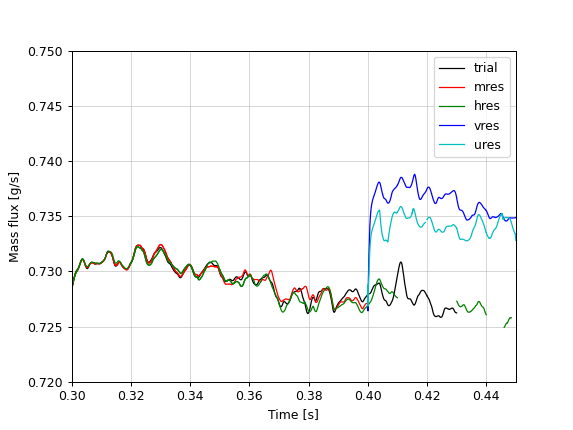

trial steady-state: 0.729058 +- 0.001645
mres steady-state: 0.729931 +- 0.001441
hres steady-state: 0.729276 +- 0.001734
vres steady-state: 0.736311 +- 0.001352
ures steady-state: 0.734025 +- 0.001015


In [124]:
'''
['Mass flux at inlet', 'Mass flux at outlet_axial', 'Mass flux at outlet_radial', 'Mass flux at walls',
'Maximum density', 'Maximum pressure', 'Maximum velocity', 'Minimum density', 'Minimum pressure',
'Momentum flux at inlet', 'Momentum flux at outlet_axial', 'Momentum flux at outlet_radial',
'Momentum flux at walls', 'Net mass flux', 'time']
'''
varPlotted = 'Mass flux at inlet'
scalingFun = lambda x: -1000*x
unit = 'Mass flux [g/s]'
startOffset=100
#kernel = np.hamming(1024)
#kernel /= np.sum(kernel)

fig=plt.figure()
ax=fig.add_subplot(111)
#ax.set_xscale('log')
#ax.set_yscale('log')
plt.grid(alpha=.5)
cList=['k','r','g','b','c','m','y']
n=0
for f in ["trial","mres","hres","vres","ures"]:
    H, ordered_groups, end_indices = read_file(topLevel+f+'.h5')
    steadyStateData=[]
    for i in range(len(ordered_groups)):
        G = H[ordered_groups[i]]
        y_ = scalingFun( G[varPlotted][startOffset:end_indices[ordered_groups[i]]] )
        t_ = G['time'][:end_indices[ordered_groups[i]]][startOffset:startOffset+len(y_)]
        #unit = G[varPlotted].attrs['unit']
        #y_smooth = np.convolve(y_,kernel,'same')
        if i==0: l=f
        else: l=None
        ax.plot(t_, y_, label=l,lw=1,c=cList[n])
        #ax.plot(t_, y_smooth,label=None,lw=1,c='r')
        
        # Define steady state for this simulation as being after t=0.3s
        if np.any(t_>0.3): 
            steadyStateData.extend(y_[t_>0.3])
    
    H.close()
    
    print("%s steady-state: %f +- %f" % (f,np.nanmean(steadyStateData),np.nanstd(steadyStateData)))
    n+=1
    
plt.xlim(0.3,0.45)
plt.ylim(0.72,0.75)
plt.xlabel('Time [s]')
plt.ylabel(unit)
plt.legend()
plt.show()

In [ ]:
H.close()